# ASSET: Analysis of Sequences of Synchronous Events in Massively Parallel Spike Trains

The tutorial is based on the paper \[[1](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004939)\] and demonstrates a method of finding patterns of synchronous spike times (synfire chains) which cannot be revealed by measuring neuronal firing rates only.

In this tutorial, we use 50 neurons per group in 10 successive groups of a synfire chain embedded in a balanced network simulation. For more information about the data and ASSET algorithm, refer to \[[1](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004939)\].

#### References

    [1] Torre E, Canova C, Denker M, Gerstein G, Helias M, Grün S (2016) ASSET: Analysis of Sequences of     Synchronous Events in Massively Parallel Spike Trains. PLoS Comput Biol 12(7): e1004939. https://doi.org/10.1371/journal.pcbi.1004939

## 1. Explore the data and postulate the problem

We start by importing the required packages, setting up matplotlib and loading the data.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import quantities as pq
import neo
import elephant
from elephant import asset

In [2]:
%load_ext autoreload

plt.style.use('dark_background')

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 20, 12
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"
plt.rcParams['mathtext.fontset'] = 'cm'


First, we download the data, packed in NixIO structure, from https://gin.g-node.org/INM-6/elephant-data

In [3]:
!curl https://web.gin.g-node.org/INM-6/elephant-data/raw/master/dataset-2/asset_showcase_500.nix --output asset_showcase_500.nix --location

The data is represented as a `neo.Block` with one `neo.Segment` inside, which contains raw `neo.SpikeTrain`s. For more information on `neo.Block`, `neo.Segment`, and `neo.SpikeTrain` refer to https://neo.readthedocs.io/en/stable/core.html

In [4]:
with neo.NixIO('asset_showcase_500.nix', 'ro') as f:
    block = f.read_block()
segment = block.segments[0]
spiketrains = segment.spiketrains

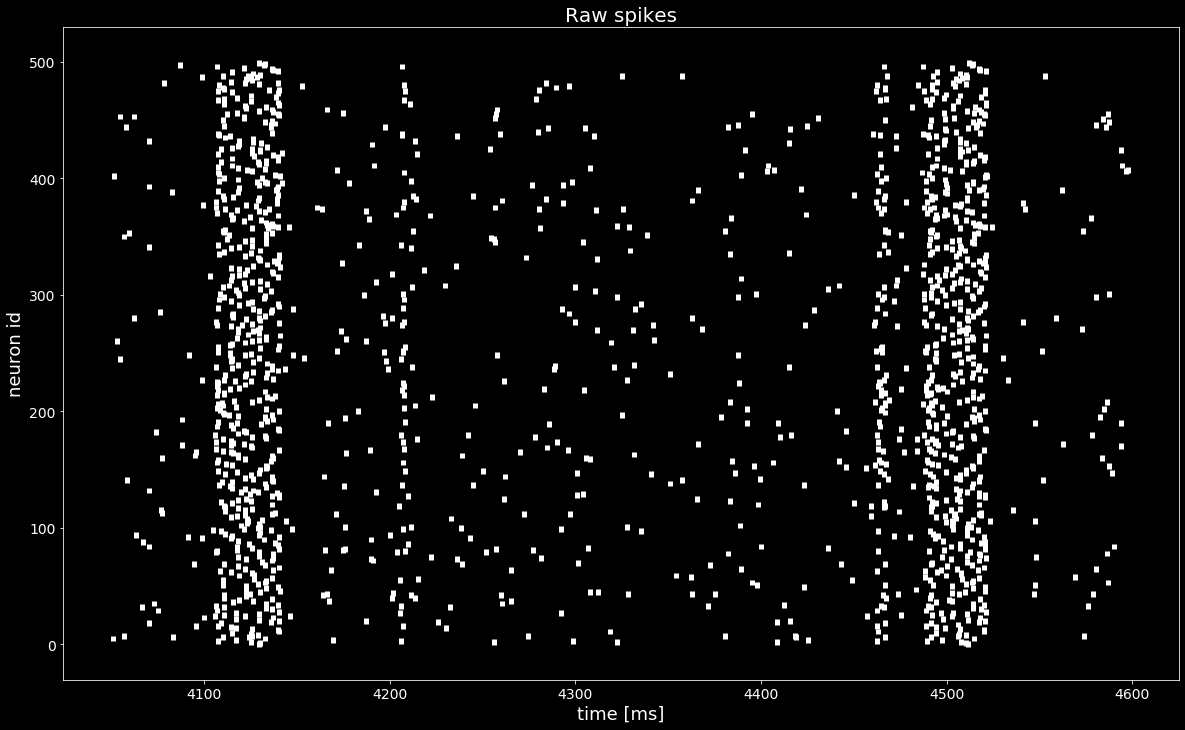

In [5]:
plt.figure()
plt.eventplot([st.magnitude for st in spiketrains], linewidths=5, linelengths=5)
plt.xlabel('time [ms]')
plt.ylabel('neuron id')
plt.title('Raw spikes')
plt.show()

Even though we see an increase of the firing rate, we cannot find a propagating activity just by looking at the raster plot above.

We want to find a permuation of rows (neurons) in `spiketrains` such that a pattern (synfire chain) appears.
The true unknown permutation is stored in the `segment.annotations['spiketrain_ordering']`. **The goal is to recreate this permutation from raw data with the statistical method ASSET.**

## 2. Applying ASSET

### 2.1. Intersection matrix

The first step is to compute the intersection matrix `imat`, the `(i,j)` entry of which represents the number of neurons spiking both at bins `i` and `j` after the binning is applied. The resultant symmetric matrix `imat` shows one off-diagonal synfire chain pattern (see the picture below).

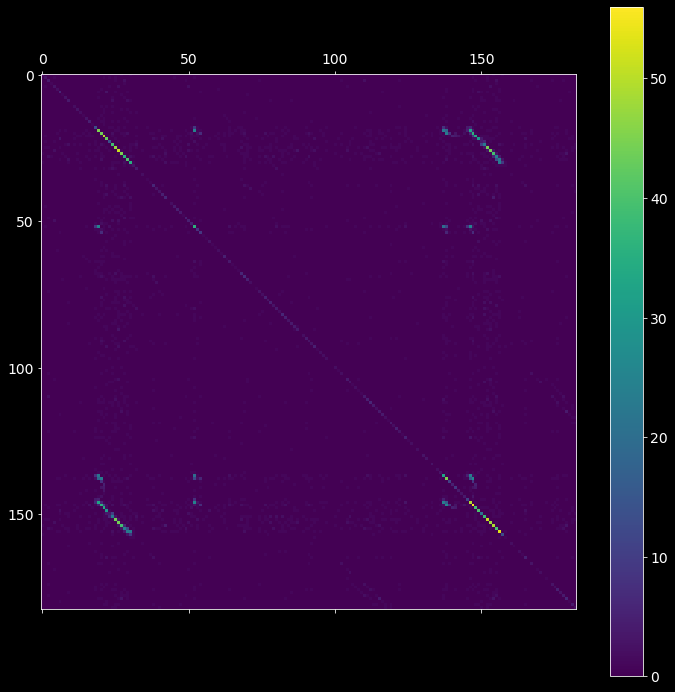

In [6]:
# 2.1.1) create ASSET analysis object
# hint: try different bin sizes, e.g. bin_size=2.5, 3.5, 4.0 ms
asset_obj = asset.ASSET(spiketrains, bin_size=3*pq.ms)

# 2.1.2) compute the intersection matrix
imat = asset_obj.intersection_matrix()
plt.matshow(imat)
plt.colorbar();

### 2.2. Analytical probability matrix

The second step is to estimate the probability $P_{null}$ that non-zero entries in `imat` occurred by chance. The resultant `pmat` matrix is defined as the probability of having strictly fewer coincident spikes at bins `i` and `j` strictly than the observed overlap (`imat`) under the null hypothesis of independence of the input spike trains.

compute rates by boxcar-kernel convolution...
compute the prob. that each neuron fires in each pair of bins...
compute the probability matrix by Le Cam's approximation...
substitute 0.5 to elements along the main diagonal...


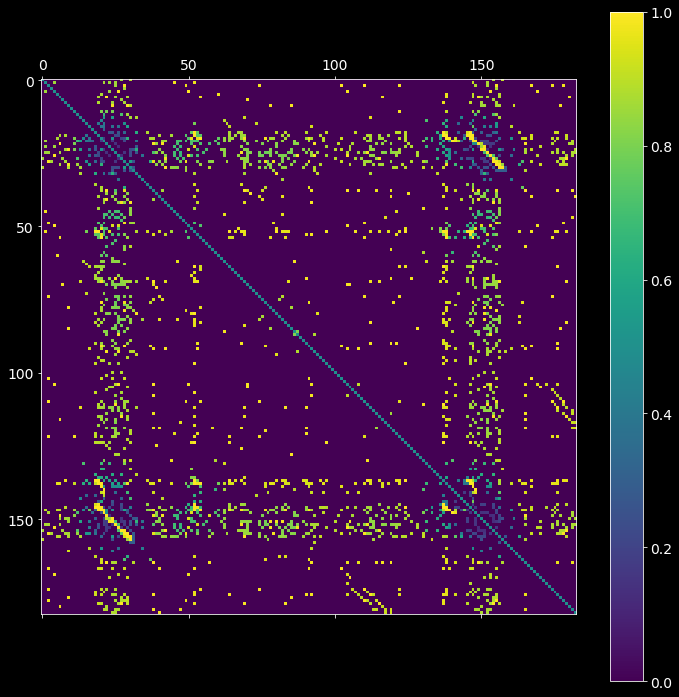

In [7]:
pmat = asset_obj.probability_matrix_analytical(imat, kernel_width=50*pq.ms)
plt.matshow(pmat)
plt.colorbar();

### 2.3. Joint probability matrix

The third step is postprocessing of the analytical probability matrix `pmat`, obtained from the previous step. Centered at each (i,j) entry of `pmat` matrix, we apply a diagonal kernel with shape `filter_shape` and select the top `nr_largest` probabilities of (i,j) neighborhood (defined by `filter_shape`), and compute the significance of these `nr_largest` joint neighbor probabilities. The resultant `jmat` matrix is a "dilated" version of `imat`.

This step is most time consuming. If you have PyCUDA or PyOpenCL installed, set `ELEPHANT_USE_CUDA` or `ELEPHANT_USE_OPENCL` environment flag to `1`.

In [8]:
os.environ['ELEPHANT_USE_OPENCL'] = '0'
# try different filter_shapes, e.g. filter_shape=(7,3)
jmat = asset_obj.joint_probability_matrix(pmat, filter_shape=(11, 3), n_largest=3)

Joint survival function: 100%|██████████| 47838/47838 [00:06<00:00, 7400.11it/s]


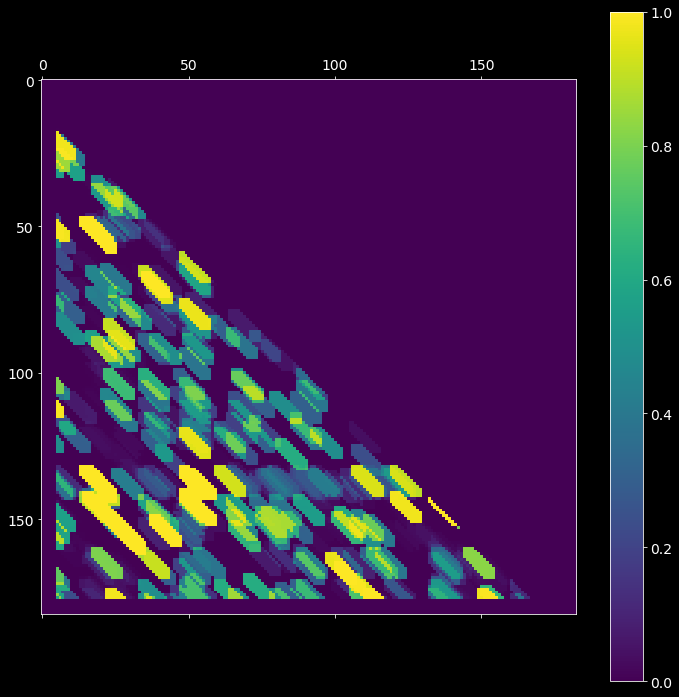

In [9]:
plt.matshow(jmat)
plt.colorbar();

### 2.4. Mask matrix

After setting significance thresholds $\alpha_P$ and $\alpha_J$ for the corresponding matrices $P$ (probability matrix `pmat`) and $J$ (joint probability matrix `jmat`), we check the entries for significance. The resultant boolean mask matrix `mmat` is then defined as

$$
M_{ij} = 1_{P_{ij} > \alpha_P} \cdot 1_{J_{ij} > \alpha_J}
$$


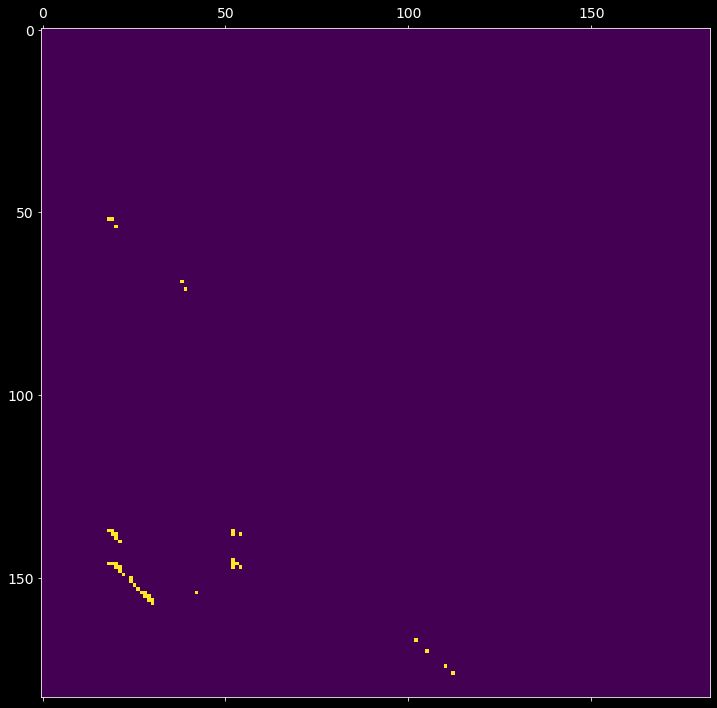

In [10]:
# hint: try different alphas for pmat and jmat
# hint: try alphas in range [0.99, 1-1e-6]
# hint: you can call 'asset.ASSET.mask_matrices(...)' without creating the asset_obj
alpha = .99
mmat = asset_obj.mask_matrices([pmat, jmat], [alpha, alpha])
plt.matshow(mmat);

### 2.5. Find clusters in the mask matrix

Each entry (i,j) of the mask matrix $M$ from the previous step is assigned to a cluster id. A cluster is constrained to have at least `min_neighbors` number of associated elements with at most `eps` intra-distance (within the group). The cluster index, or the (i,j) entry of the resultant `cmat` matrix, is:

1. a positive int (cluster id), if (i,j) is part of a cluster;
2. `0`, if $M_{ij}$ is non-positive;
3. `-1`, if the element (i,j) does not belong to any cluster.


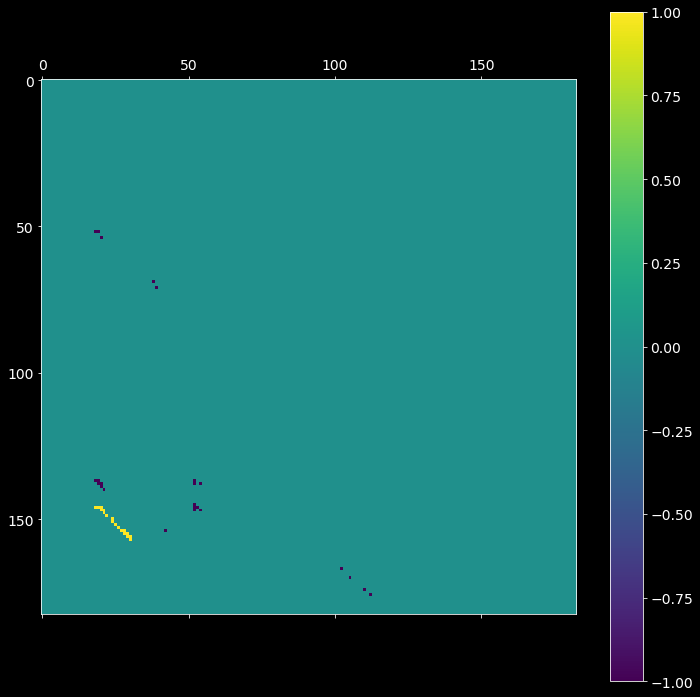

In [11]:
# hint: you can call asset.ASSET.cluster_matrix_entries(...) without creating the asset_obj
cmat = asset_obj.cluster_matrix_entries(mmat, max_distance=11, min_neighbors=10, stretch=5)
plt.matshow(cmat)
plt.colorbar();

### 2.6. Sequences of synchronous events

Given the input spike trains, two arrays of bin edges from step 2.2 and the clustered intersection matrix `cmat` from step 2.5, extract the sequences of synchronous events (synfire chains).


In [12]:
sses = asset_obj.extract_synchronous_events(cmat)
sses.keys()

dict_keys([1])

In [13]:
cluster_id = 1
cluster_chain = []
for chain in sses[cluster_id].values():
    cluster_chain.extend(chain)

_, st_indices = np.unique(cluster_chain, return_index=True)
st_indices = np.take(cluster_chain, np.sort(st_indices))

reordered_sts = [spiketrains[idx] for idx in st_indices]
spiketrains_not_a_pattern = [spiketrains[idx] for idx in range(len(spiketrains))
                      if idx not in st_indices]
reordered_sts.extend(spiketrains_not_a_pattern)

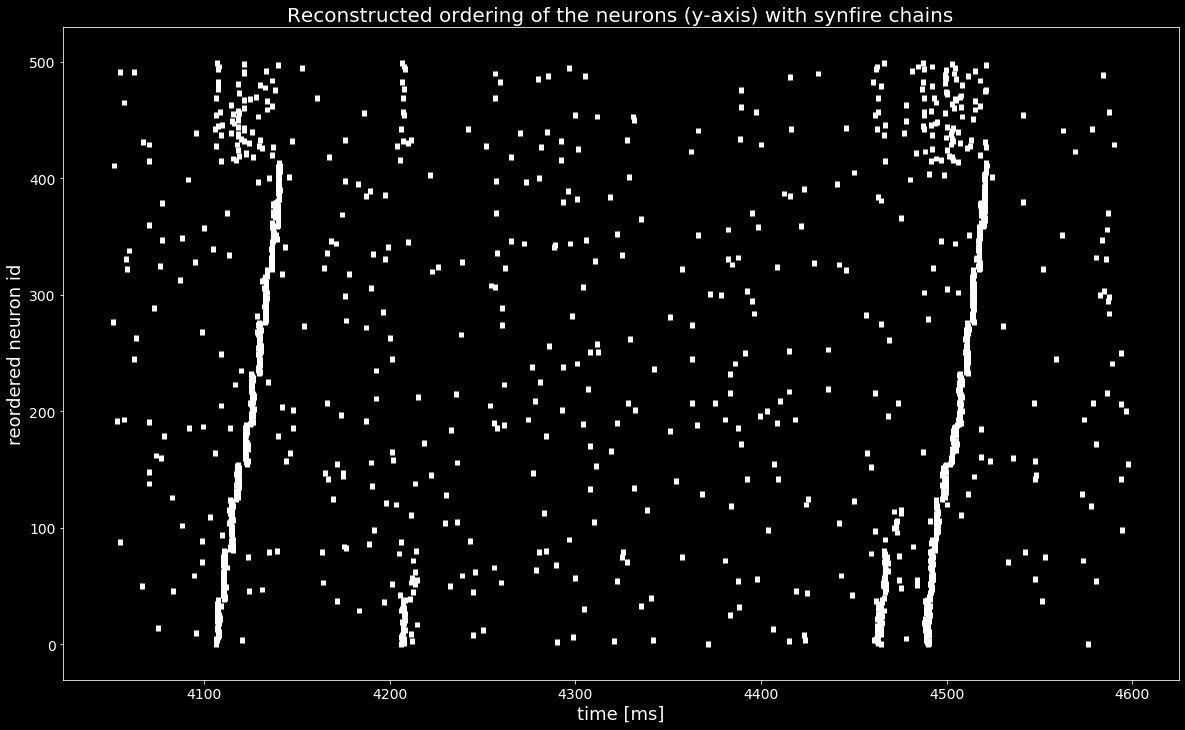

In [14]:
plt.figure()
plt.eventplot([st.magnitude for st in reordered_sts], linewidths=5, linelengths=5)
plt.xlabel('time [ms]')
plt.ylabel('reordered neuron id')
plt.title('Reconstructed ordering of the neurons (y-axis) with synfire chains');

#### With the sequences of synchronous events `sses` we found a permutation of the spiketrains that reveals the synfire chain as in the ground truth ordering in the last Figure, shown below..

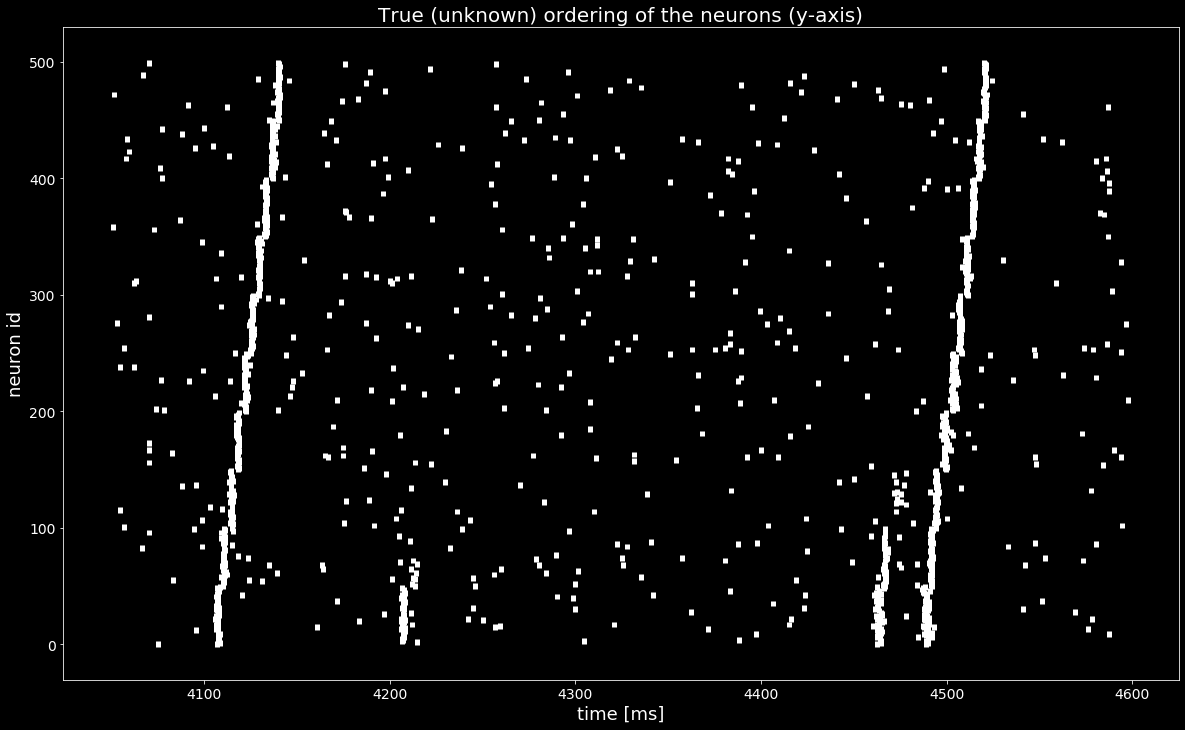

In [15]:
ordering_true = segment.annotations['spiketrain_ordering']
spiketrains_ordered = [spiketrains[idx] for idx in ordering_true]

plt.figure()
plt.eventplot([st.magnitude for st in spiketrains_ordered], linewidths=5, linelengths=5)
plt.xlabel('time [ms]')
plt.ylabel('neuron id')
plt.title('True (unknown) ordering of the neurons (y-axis)')
plt.show()